# Socket Serializer Performance

##### Preload

1) Install Python 3; Restart VSCode
2) Run "pip install pandas numpy"

In [2]:
import os
import os.path
import subprocess
from typing import Tuple
from matplotlib.container import BarContainer
import pandas as pd
import numpy as np


def find_report_bounds(lines: list) -> Tuple[int, int]:
    start = 0
    for i, line in enumerate(lines):
        if line.strip().startswith('- - - - - - - -'):
            if start == 0:
                start = i
            else:
                return (start, i)

    raise RuntimeError(
        'Performance report is not found in the command executed')


def parse_test_report(output: str, comparison_table: dict, errors: list[list[float]], has_title: bool = False, filter: str = None):
    lines = output.splitlines()
    (start, end) = find_report_bounds(lines)

    def pairwise(t):
        it = iter(t)
        return zip(it, it)

    title = ''
    if has_title:
        title = lines[start+1]
        start += 2
    else:
        start += 1

    # After anchor above the test results are following. First line - name.
    # Second line - the perf test result with timestamp
    curr_errors = []
    for test_name, test_description in pairwise(lines[start:end]):
        test_name = test_name.strip()
        if filter is not None and not test_name.startswith(filter):
            continue

        test_time = float(test_description.strip().split(' ')[0])
        curr_errors.append(float(test_description.strip().split(' ')[3]))

        if test_name in comparison_table:
            comparison_table[test_name].append(test_time)
        else:
            comparison_table[test_name] = [test_time]

    errors.append(curr_errors)
    return title


def get_installed_node_version() -> str:
    node_version_cmd = subprocess.run(
        'node -v', capture_output=True, shell=True)
    if node_version_cmd.returncode == 0:
        return node_version_cmd.stdout.strip().decode('utf-8')
    raise RuntimeError(
        'Failed to fined node version. Error code: {0}' % node_version_cmd.returncode)


def run_npm_script(script: str) -> str:
    cwd = os.path.join(os.getcwd(), '..')
    completed_process = subprocess.run(
        "npm run {0}".format(script), capture_output=True, shell=True, cwd=cwd)
    if completed_process.returncode == 0:
        return completed_process.stdout.decode('utf-8')
    raise RuntimeError(
        "'npm run {0}' failed. Exit code: {1}".format(script, completed_process.returncode))


def plot_performance_results(resultTable: dict, testNames: list[str], errors: list[list[float]]):
    data_frame_input = dict(map(lambda x: (x, []), testNames))
    max = 0

    for i, test_name in enumerate(testNames):
        test_data = list(map(lambda x: x[i], resultTable.values()))
        max = np.max(test_data) if np.max(test_data) > max else max
        data_frame_input[test_name].extend(test_data)

    indexes = list(resultTable.keys())

    data_frame = pd.DataFrame(data_frame_input, index=indexes)
    bars = data_frame.plot.barh(
        figsize=(20, len(indexes)), xerr=errors, width=0.8)
    bars.set_xlim(0, max + max / 2)

    index = 0
    data_frame_values = list(data_frame_input.values())
    for container in bars.containers:
        if isinstance(container, BarContainer):
            value_and_error = list(
                zip(data_frame_values[index], errors[index]))
            bars.bar_label(container, map(
                lambda x: '{0} ms (+/- {1} ms)'.format(x[0], x[1]), value_and_error))
            index += 1

## Version 12.0.2

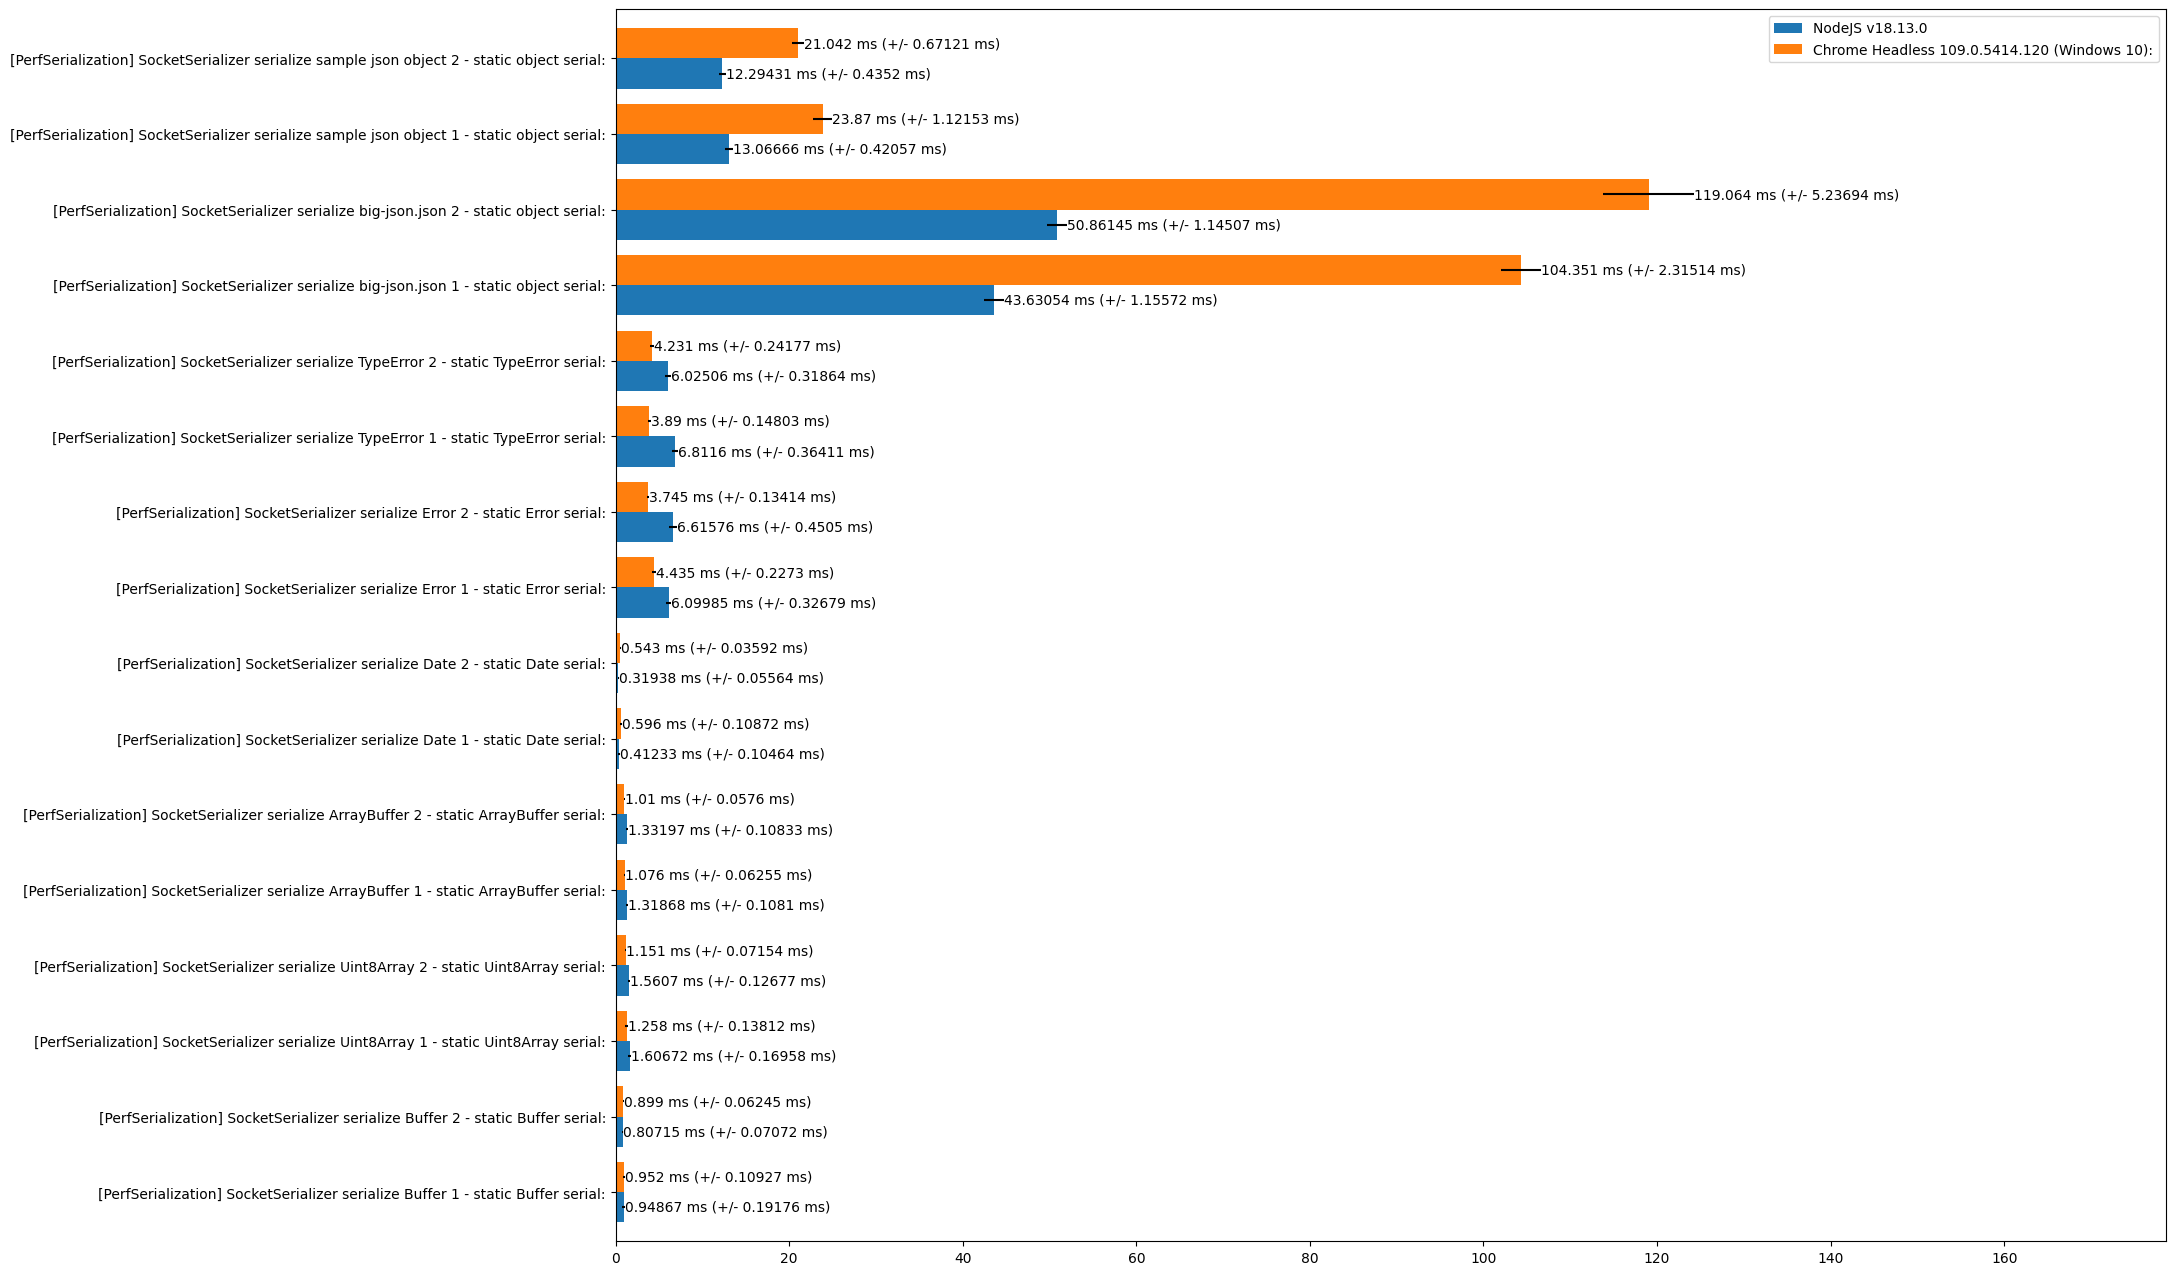

In [90]:
debug = False

if debug:
    number_of_measures = 30
    errors = np.random.rand(2, number_of_measures)
    resultTable = dict(map(lambda x: ("data_data_data_data_data_data_data_data_data_{}".format(
        x), np.random.randint(50, size=2)), range(number_of_measures)))
    node_version = 'NodeJS {0}'.format(get_installed_node_version())
    browser_version = 'Chrome 100.0.0.0 (Windows 10)'
    plot_performance_results(
        resultTable, [node_version, browser_version], errors)
else:
    errors = []
    resultTable = dict()
    filter = '[PerfSerialization]'
    node_version = 'NodeJS {0}'.format(get_installed_node_version())
    node_perf_res = run_npm_script('perf:node')
    parse_test_report(node_perf_res, resultTable, errors, filter=filter)
    browser_perf_res = run_npm_script('perf:browser')
    browser_version = parse_test_report(
        browser_perf_res, resultTable, errors, True, filter=filter)
    plot_performance_results(
        resultTable, [node_version, browser_version], errors)


The comparison of the methods to convert string to buffer and buffer to string:

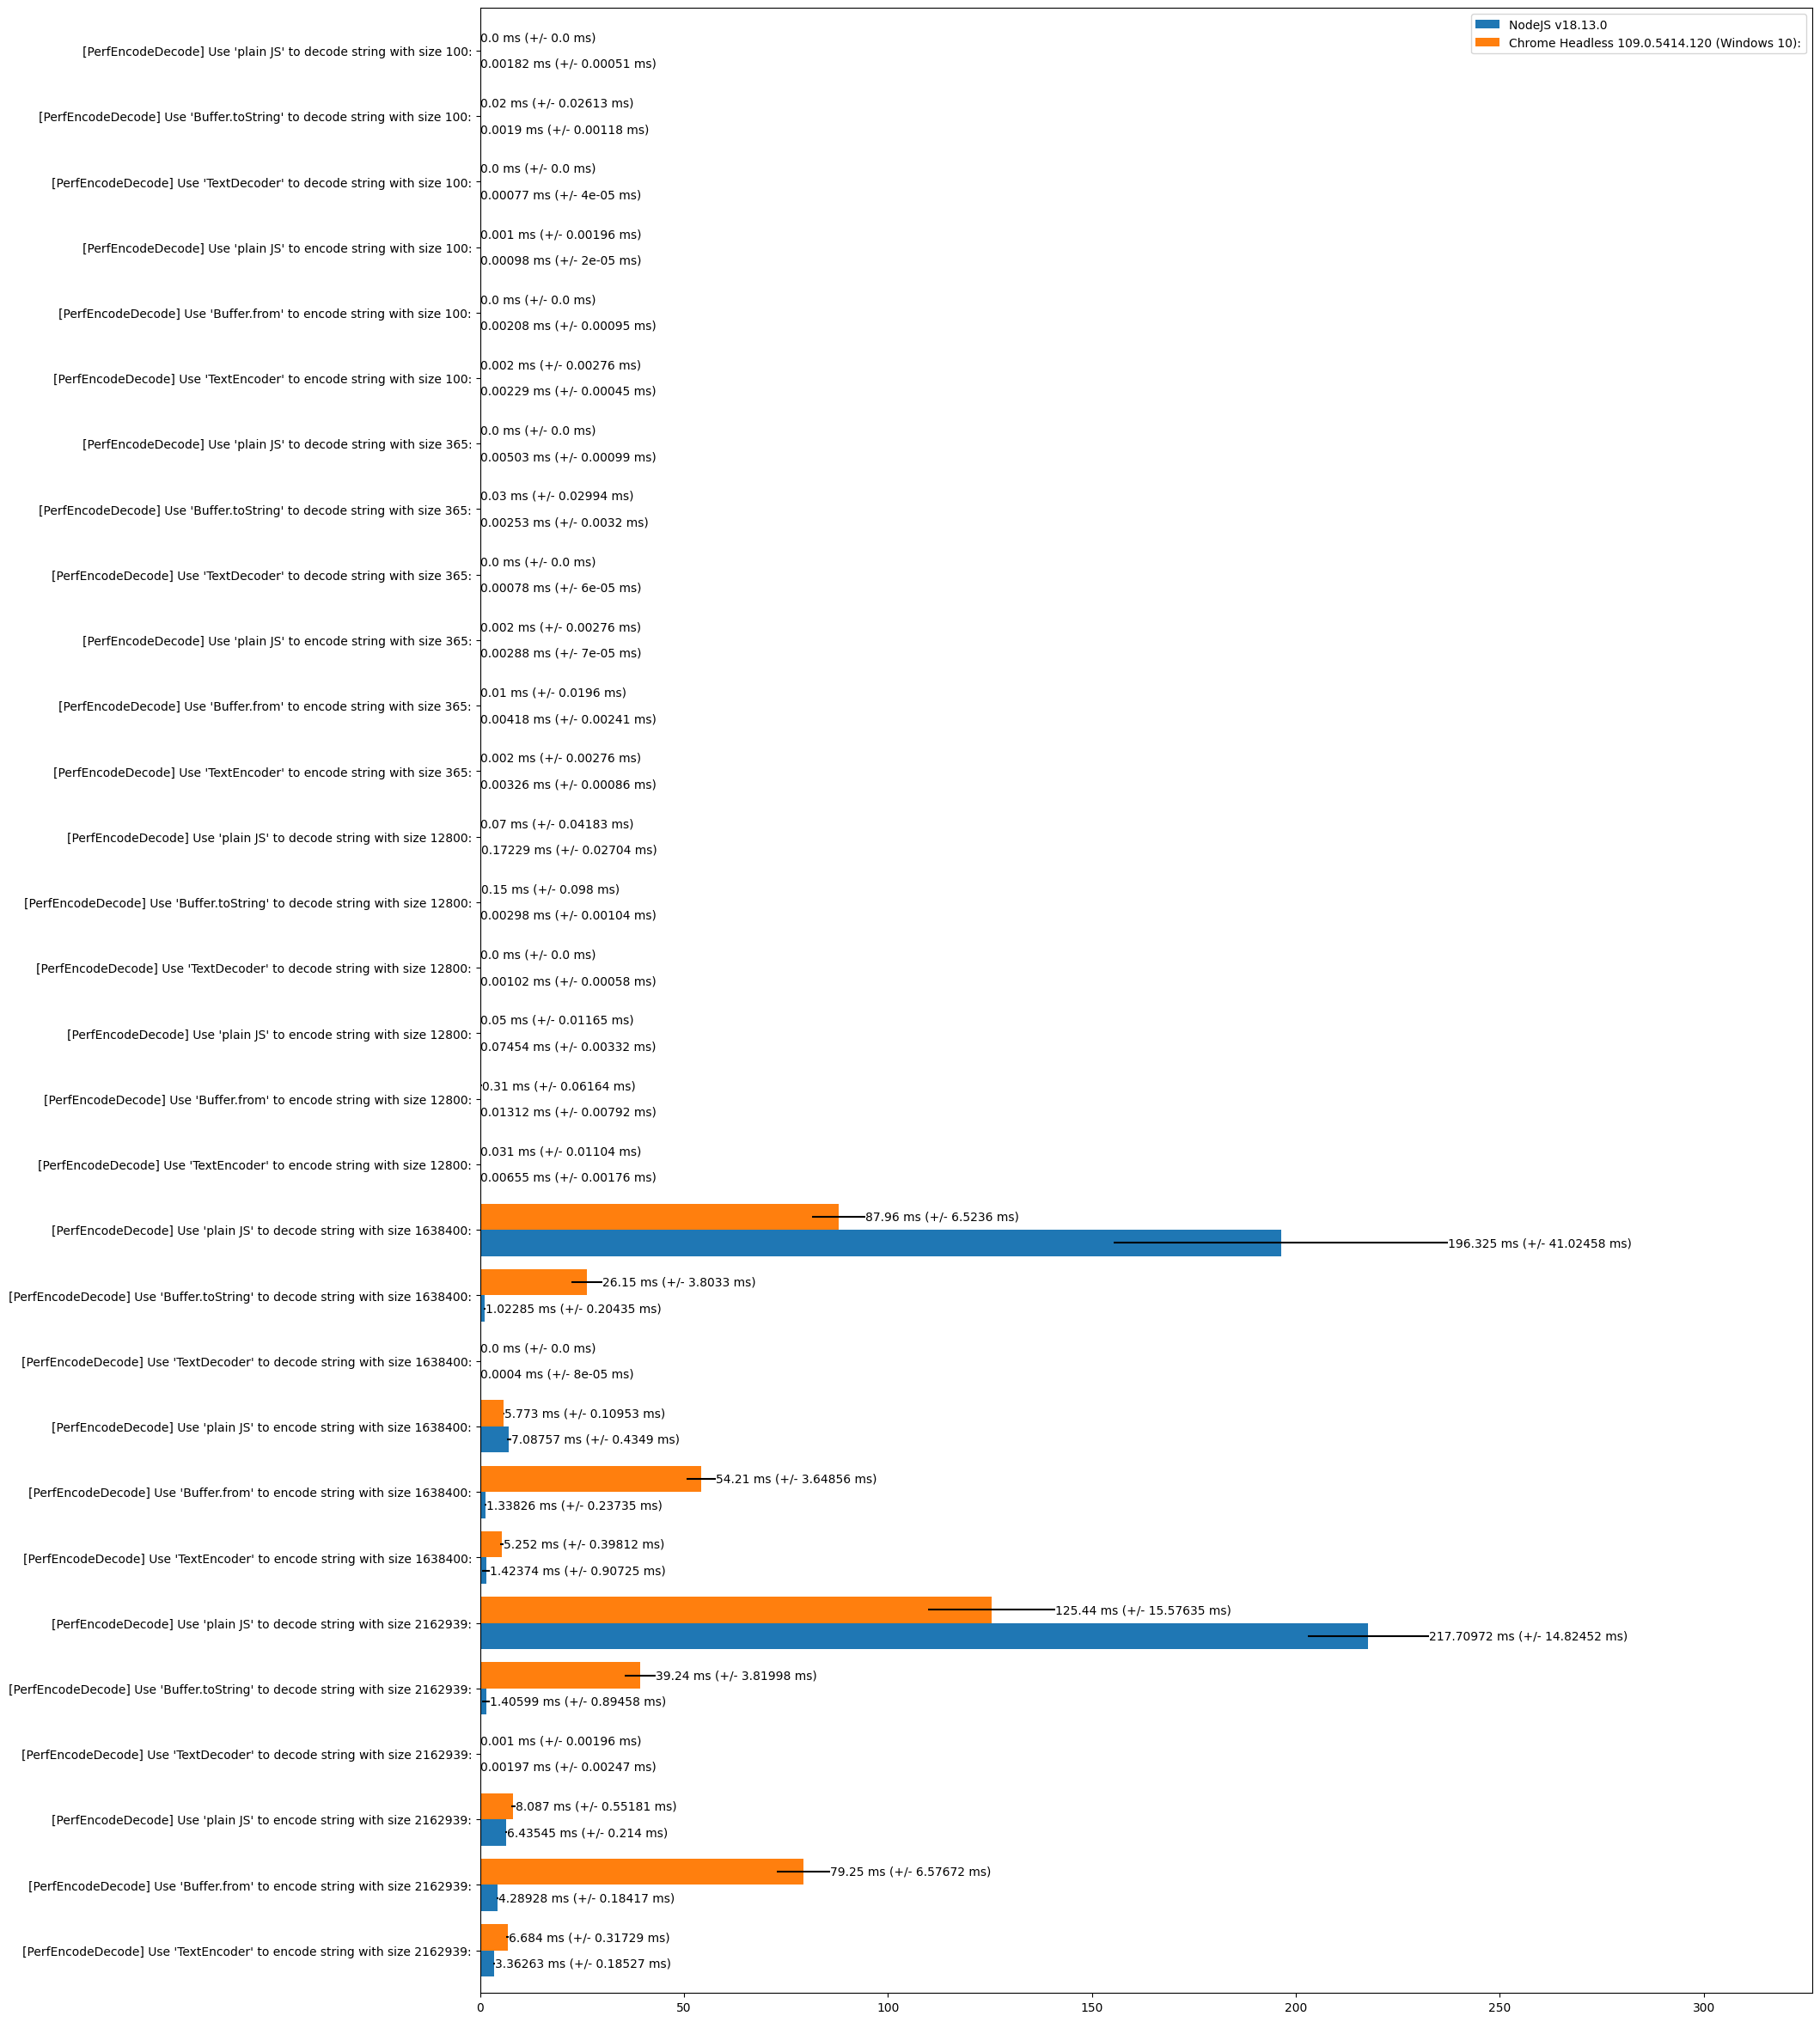

In [92]:
errors = []
resultTable = dict()
filter = '[PerfEncodeDecode]'
node_version = 'NodeJS {0}'.format(get_installed_node_version())
node_perf_res = run_npm_script('perf:node')
parse_test_report(node_perf_res, resultTable, errors, filter=filter)
browser_perf_res = run_npm_script('perf:browser')
browser_version = parse_test_report(
    browser_perf_res, resultTable, errors, True, filter=filter)
plot_performance_results(
    resultTable, [node_version, browser_version], errors)

### Version 12.0.3

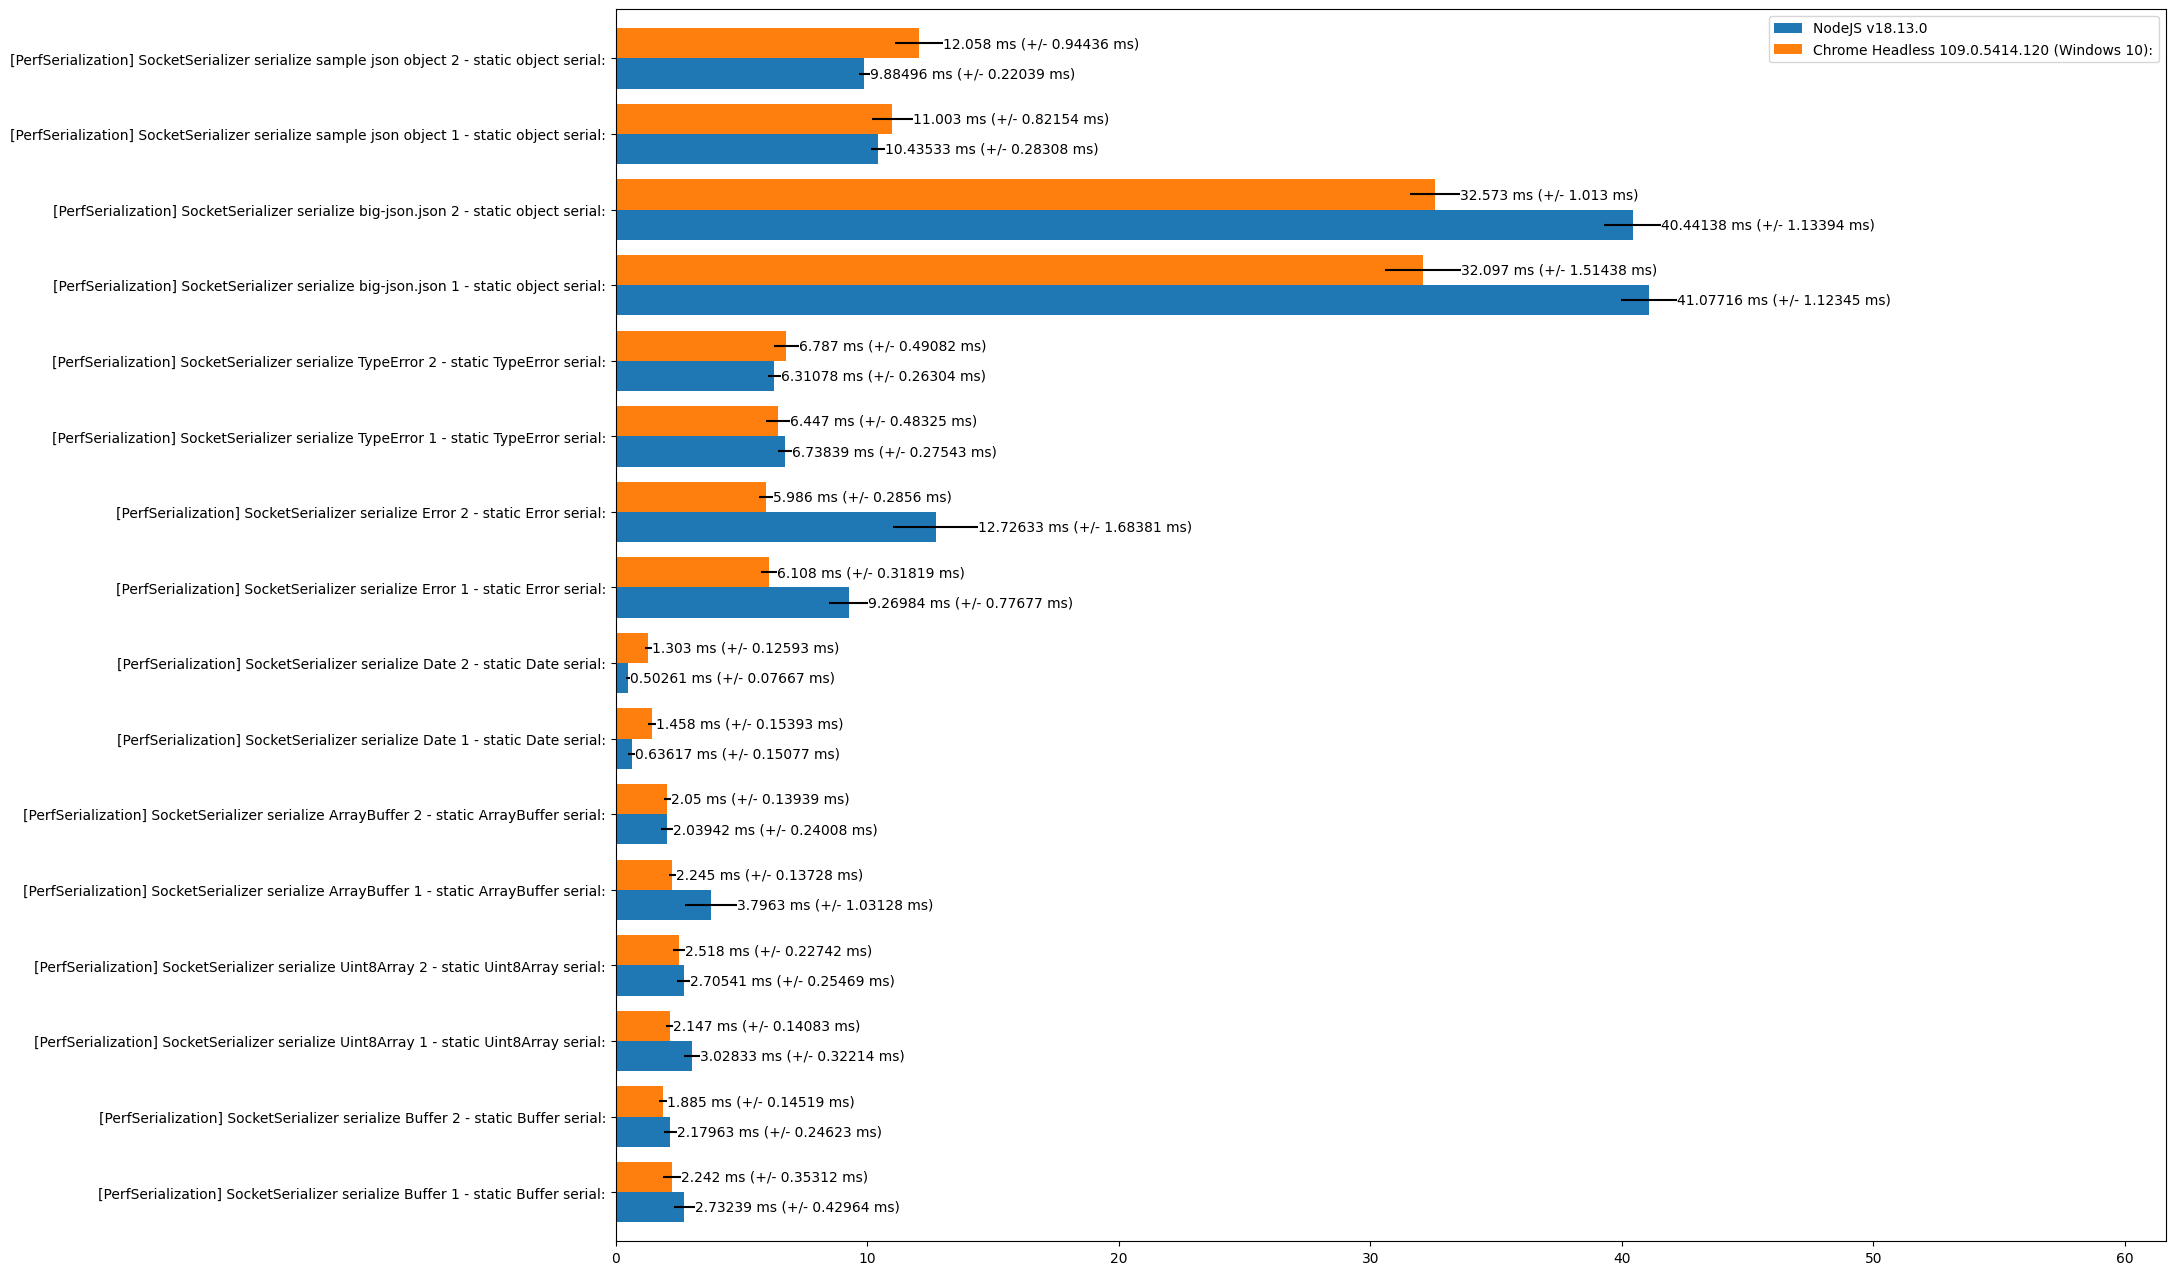

In [3]:
errors = []
resultTable = dict()
filter = '[PerfSerialization]'
node_version = 'NodeJS {0}'.format(get_installed_node_version())
node_perf_res = run_npm_script('perf:node')
parse_test_report(node_perf_res, resultTable, errors, filter=filter)
browser_perf_res = run_npm_script('perf:browser')
browser_version = parse_test_report(
    browser_perf_res, resultTable, errors, True, filter=filter)
plot_performance_results(
    resultTable, [node_version, browser_version], errors)